# Assignment 1: Locality-sensitive Hashing
Name: Phillis Ye  
StudentID: 452535825  
UPI: zye615

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
from random import randint

random.seed(1234)

## Part I: Construct LSH Hash Tables for All Documents

### (a) Load the dataset and construct a feature vector for each documnet in the dataset.


In [2]:
# read data
cora_all = pd.read_csv("cora_all", sep="\t", header=None)

In [3]:
# the first few lines of the data frame looks like:
cora_all.head()

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [4]:
# transpose the data
data = cora_all.transpose()
data.head()

# remove the first row (paper_id) and the last row (class_label)
data=data[1:-1]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [5]:
# shape of the data frame
data.shape

(1433, 2708)

By transforming the data into the format we want, the cleaned data shows there are 2708 documents and 1433 features.

### (b) Generate MinHash functions in the LSH family.

In [6]:
# define k*l hash functions
# define a large prime number p and generate random a and b values from range 0 to p-1.
# store the a and b pair values in a list.
def generate_a_b(k, l, p):
    a_b_pair = []
    for i in range (k*l):
        a = randint(0,p-1)
        b = randint(0,p-1)
        a_b_pair.append([a,b])
    return a_b_pair

# define the function to report the hash functions.
def report_formula(a_b, n, p):
    for a_b_pair in a_b:
        # get a and b values generated before from the list.
        a = a_b_pair[0]
        b = a_b_pair[1]
        print("((" + str(a) + "x+" + str(b) + ")mod " + str(p) + ")mod " + str(n))

In [7]:
# number of feature is 1433.
n=1433
# choose the prime number larger than 1433 and close to 2^power.
p=2053

# randomly generate 9 MinHash functions for 3 tables (l) with hash size (k) 3.
a_b_pair = generate_a_b(3,3,p)

print("Mathematical formulas of the hash functions would look like:")
report_formula(a_b_pair,n,p)

Mathematical formulas of the hash functions would look like:
((1805x+478)mod 2053)mod 1433
((30x+371)mod 2053)mod 1433
((143x+343)mod 2053)mod 1433
((403x+1452)mod 2053)mod 1433
((969x+71)mod 2053)mod 1433
((126x+64)mod 2053)mod 1433
((1417x+1983)mod 2053)mod 1433
((1898x+608)mod 2053)mod 1433
((373x+749)mod 2053)mod 1433


The MinHash functions have the format of ((ax+b)%p)%n where a and b are random numbers. n is the number of features we have, which is 1433. p is a large prime number, so I choose p = 2053 which is a prime number larger than 1433 and close a number of power of 2 (2^11 = 2048). I use the function `generate_a_b` to generate random a and b values with the range from 0 to p-1 and store in a list. The parameters k and l for the function decides number of a_b pairs we needed, and parameter p determines the maximum value for a and b. Then I use the function `report_formula` to print the mathematical formulation of my hash functions. Several examples are shown above.

### (c) Construct LSH hash tables using the hash functions with $l=20$ and $k=10$ .

In [8]:
# add the rows (features) that have the value 1 in each documents to a new data list.
def transform_data(data):
    # cols equals the number of documents
    cols = len(data.columns)
    # create lists in a list that values in trans_data[i] are the rows that have value 1 in ith document
    trans_data = [[] for i in range (cols)]
    # i stands for each document
    for i in range(cols):
        # r stands for each feature, using r+1 because the row starts from 1 in the data frame.
        for r in range(len(data[i])):
            if data[i][r+1] == 1:
                trans_data[i].append(r)
    return trans_data

# define a function that hash the data into a sigmatrix with randomly generated hash functions.
def MinHash(data, a_b):
    # cols stand for the number of documents
    # the number of rows in sigmatrix equals to the number of hash functions
    cols, sigrows = len(data), len(a_b)
    # initialise the sigmatrix as a numpy array with number of rows equal sigrows and number of columns equals number of documents
    sigmatrix = np.zeros((sigrows,cols))
    
    # for each sigrows, use an a_b pairs as coefficients for the hash functions.
    for k in range(sigrows):
        a = a_b[k][0]
        b = a_b[k][1]
        # for each documents
        for c in range (cols):
            # initialise the value as an infinite.
            value = float("Inf")
            # rows - get all the features that have value 1 in such document
            rows = data[c]
            # for each features
            for r in rows:
                # compute the hash value for that feature
                hashvalue = ((a*r+b)%p)%n
                # get the smallest hash value for that feature
                if value > hashvalue:
                    value = hashvalue
            sigmatrix[k][c] = value
    
    return sigmatrix

# combine the sigmatrix for all tables l.
def sigmatrix_construction(k,l,data,a_b_coef):
    res = np.empty((l,k,len(data)))
    for i in range(l):
        a_b = a_b_coef[k*i:k*(i+1)]
        matrix = MinHash(data, a_b)
        res[i] = matrix
    return res
    
# generate random coefficients as a for universal hash function g
def random_coefficients(k, l, p):
    # store the coefficient in numpy array
    coef_list = np.zeros((l,k))
    for i in range(l):
        for j in range(k):
            coef_list[i][j] = randint(0,p-1)
    return coef_list

# construct the hash table
def table_construction(sigmatrix, coef_list, data):
    # create the empty numpy array to store the hashed table, with columns represent each documents, number of rows equals l.
    hashed = np.empty((len(sigmatrix),len(data)))
    
    # for each k-dimensional bands (l) hash a table
    for l in range(len(sigmatrix)):
        hashed[l] = coef_list[l].dot(sigmatrix[l])
        hashed[l] = (hashed[l]%p)%n
    
    return hashed

In [9]:
# with choice for number of tables (l=20) and hash size (k=10).
k=10
l=20
# generate k*l = 200 pairs of a,b coefficients.
a_b_pairs = generate_a_b(k,l,p)
# generate k*l = 200 coefficients for hashed table.
coef = random_coefficients(k,l,p)

# transform the data into a list of features that have value 1 for each document.
trans_data = transform_data(data)

# consturct sigmatrix
sigmatrix_all = sigmatrix_construction(k,l,trans_data,a_b_pairs)
# construct the hash table
hashed_table = table_construction(sigmatrix_all, coef, trans_data)

Text(33.0, 0.5, 'hash size k')

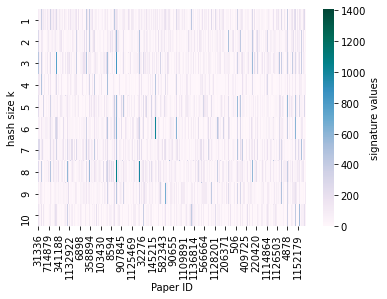

In [10]:
# store the first band sigmtrix in a dataframe with index from 1 to 10 and columns with the paper id.
df = pd.DataFrame(sigmatrix_all[0], index = [1,2,3,4,5,6,7,8,9,10], columns = cora_all[0])

# The heatmap plot for one table with all documents hashed into the hash table.
# x axis is the paper IDs, y axis is the k value from 1 to 10, the heat values are the signature values.
sns.heatmap(df, cbar_kws={'label': 'signature values'}, cmap="PuBuGn")
plt.xlabel("Paper ID")
plt.ylabel("hash size k")

With choice for number of tables ($l=20$) and hash size ($k=10$), I firstly used `generate_a_b` function to generate $k*l=200$ random values of a and b for MinHash functions and used `random_coefficients` to generate coefficients for hashed table and stored in a $k*l$ numpy array. Then I transformed the data into a nested list where list[$i$] stores the features that have value 1 for the $i$th document. Then the `sigmatrix_construction` function used MinHash functions to calculate signature values and store in the sigmatrix with shape (20,10,2708) and then using `table_construction` function to hash the signature values in the sigmatrix into hashed table. The final heatmap plot shows the first table with all documents hashed into the hash table.

## Part II: Perform Nearest Neighbor Search for Query dataset

In [11]:
# read the query data
cora_query = pd.read_csv("cora_query", sep="\t", header=None)
display(cora_query)

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
2,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
3,217139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based
4,1128990,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Genetic_Algorithms
5,1106418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
6,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning


In [12]:
# preprocess the data
data_query = cora_query.transpose()
data_query = data_query[1:-1]
data_query.shape

(1433, 7)

The query data has 7 documents and 1433 features.

In [13]:
# hashed the query data into the hashed table
trans_data_query = transform_data(data_query)

sigmatrix_query = sigmatrix_construction(k,l,trans_data_query,a_b_pairs)
hashed_query_table = table_construction(sigmatrix_query, coef, trans_data_query)

In [14]:
# find all the documents that collide with q in at least one hash table.
def collide_documents(q, all):
    # create a nested list to store the 7 queries.
    # collided[i] is the set of documents collide with query i.
    collided = [[] for i in range(7)]

    # for each query document
    for d in range(7):
        # for each band
        for l in range(len(q)):
            # for each document in the hashed table
            for c in range(len(all[l])):
                # if the hashed value of document c equals the hashed value of the query document d in a band
                # if document c not found before, then append the document c into the collide list for query document d.
                if all[l][c] == q[l][d]:
                    if c not in collided[d]:
                        collided[d].append(c)

    return collided

# the format of the final result
def output_format(sorted_sim):
    data = np.empty((10,4),dtype=object)
    # find the top 10 documents with highest similarity
    for i in range(10):
        # rank starts at 1 so need to add 1 to the index i.
        rank = i+1
        # find the document index with rank i+1
        document = sorted_sim[i][0]
        # find the paper_id of the document in original data frame
        paper_id = cora_all.iloc[document,0]
        # store the jaccard_similarity with 3 df.
        jaccard_sim = round(sorted_sim[i][1],3)
        # find the class_label of the document in original data frame
        class_label = cora_all.iloc[document,1434]
        # store the data in a list
        data[i]=[rank,paper_id,jaccard_sim,class_label]

    # create a data frame to store all the data for top 10 documents.
    result = pd.DataFrame(data, columns = ['rank','paper_id','Jaccard_sim','class_label'])
    return result

Before calculating the Jaccard similarity, the query data is transformed as before and signature values are stored in `sigmatrix_query` and hashed into `hashed_query_table`.

### (a) Report the list of top-10 documents with highest signature-based Jaccard similarity in descending order for each query.

In [15]:
# calculate the signature-based Jaccard similarity
def sigmatrix_similarity(collide_docu, signature, q, simi_dict):
    for c in collide_docu:
        # find number of same signature value
        same_sig = np.sum(q==signature[:,c])
        # similarity equals number that have same signature value divides by the length of sigmatrix
        simi_dict[c].append(same_sig/len(q))
    return simi_dict


def search_result(collide_documents,l,sig_all,sig_q):
    search_res = list()
    sorted_similarity = list()
    
    # for each query document
    for q in range(len(collide_docu)):
        # find collide documents for query q
        collided = collide_docu[q]

        sig_simi = {}
    
        for c in collided:
            sig_simi[c] = []
        
        # find sigmatrix similarity for q and collide documents in each band
        for band in range(l):
            sig_simi = sigmatrix_similarity(collided, sig_all[band], sig_q[band][:,q], sig_simi)
    
        # average the 20 bands similarity
        for i in collided:
            sig_simi[i] = sum(sig_simi[i])/len(sig_simi[i])
        
        # sort the result in the descending order wrt similarity.
        sort_simi = sorted(sig_simi.items(), key=lambda x:x[1], reverse=True)
        # store all the sorted result
        sorted_similarity.append(sort_simi)
        # format the top ten ranked result
        result_table = output_format(sort_simi)
        search_res.append(result_table)
        
    return search_res, sorted_similarity

In [16]:
# find the collide documents for each query.
collide_docu = collide_documents(hashed_query_table,hashed_table)

search_res, sort_simi = search_result(collide_docu, l, sigmatrix_all, sigmatrix_query)

for q in range(7):
    print(str(q+1) + ". For query document", cora_query.iloc[q,0], "the top-10 documents with highest Jaccard similarity is:")
    display(search_res[q])

1. For query document 31336 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,31336,1,Neural_Networks
1,2,561595,0.105,Probabilistic_Methods
2,3,531348,0.08,Probabilistic_Methods
3,4,189623,0.055,Probabilistic_Methods
4,5,1131471,0.055,Case_Based
5,6,43698,0.05,Neural_Networks
6,7,892139,0.05,Reinforcement_Learning
7,8,376704,0.05,Case_Based
8,9,1114398,0.05,Neural_Networks
9,10,910,0.045,Neural_Networks


2. For query document 1106406 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1106406,1,Reinforcement_Learning
1,2,1108728,0.09,Rule_Learning
2,3,3191,0.075,Probabilistic_Methods
3,4,294145,0.07,Rule_Learning
4,5,28287,0.07,Reinforcement_Learning
5,6,1120169,0.065,Theory
6,7,346292,0.06,Neural_Networks
7,8,1120650,0.055,Rule_Learning
8,9,1121603,0.055,Neural_Networks
9,10,45605,0.05,Genetic_Algorithms


3. For query document 37879 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,37879,1,Probabilistic_Methods
1,2,416455,0.095,Genetic_Algorithms
2,3,3237,0.09,Probabilistic_Methods
3,4,1717,0.085,Probabilistic_Methods
4,5,1111304,0.07,Reinforcement_Learning
5,6,1152143,0.07,Theory
6,7,3217,0.065,Theory
7,8,1114838,0.065,Theory
8,9,72101,0.06,Neural_Networks
9,10,1128227,0.055,Genetic_Algorithms


4. For query document 217139 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,217139,1,Case_Based
1,2,1959,0.1,Case_Based
2,3,194645,0.08,Reinforcement_Learning
3,4,277263,0.06,Rule_Learning
4,5,1119654,0.055,Case_Based
5,6,1952,0.055,Case_Based
6,7,1154500,0.05,Case_Based
7,8,34266,0.05,Neural_Networks
8,9,217115,0.04,Theory
9,10,55968,0.04,Reinforcement_Learning


5. For query document 1128990 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1128990,1,Genetic_Algorithms
1,2,594011,0.145,Genetic_Algorithms
2,3,13717,0.115,Rule_Learning
3,4,6941,0.11,Rule_Learning
4,5,1121659,0.1,Probabilistic_Methods
5,6,1104749,0.095,Genetic_Algorithms
6,7,6925,0.085,Neural_Networks
7,8,593260,0.085,Genetic_Algorithms
8,9,50807,0.08,Genetic_Algorithms
9,10,25181,0.075,Neural_Networks


6. For query document 1106418 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1106418,1,Theory
1,2,289780,0.075,Genetic_Algorithms
2,3,261040,0.075,Case_Based
3,4,10177,0.07,Theory
4,5,1104946,0.07,Theory
5,6,1153703,0.065,Case_Based
6,7,1152307,0.065,Case_Based
7,8,1152448,0.065,Case_Based
8,9,1152975,0.065,Case_Based
9,10,45061,0.065,Theory


7. For query document 1061127 the top-10 documents with highest Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1061127,1,Rule_Learning
1,2,84459,0.135,Theory
2,3,1116181,0.135,Theory
3,4,1110256,0.135,Theory
4,5,13885,0.105,Neural_Networks
5,6,136767,0.1,Theory
6,7,28456,0.1,Theory
7,8,50980,0.1,Case_Based
8,9,1106630,0.1,Neural_Networks
9,10,181782,0.095,Reinforcement_Learning


Firstly, using the `collide_documents` function to find the set of documents that collide with each query document in at least one hash table. Then the `search_result` function calculates the signature-based Jaccard similarity for the collide documents and each query document. It is calculated by the number of same signature value divide by k in each band, then average the similarity for 20 bands. Then find the information for the top ten similarity documents for each query and the results are shown above.

### (b) Report the list of top-10 documents with highest bitvector-based Jaccard similarity in descending order for each query.

In [17]:
# calculate the bitvector based Jaccard similarity for each query document q.
def bitvector_similarity(all_d,q):
    dic = {}
    # for each of 2708 documents
    for c in range(len(all_d[0])):
        # find all the feature values for document c
        document = all_d[:,c]
        # numerator of the similarity equation is the number of features that are both 1
        numerator = np.sum((q==1) & (all_d[:,c]==1))
        # denominator of the similarity equation is the number of features that at least have a 1.
        # which is the same as the total number of features minus the number of features that are both 0.
        denominator = len(all_d[:,0]) - np.sum((q==0) & (all_d[:,c]==0))
        # calculate the similarity
        similarity = numerator/denominator
        dic[c] = similarity
    return dic

In [18]:
# transform data frame to numpy arrays
all_data = data.to_numpy()
query_data = data_query.to_numpy()

ground_truth = list()

# for each query document q.
for q in range(len(query_data[0])):
    # find the bitvector similarity for query q.
    bit_simi = bitvector_similarity(all_data, query_data[:,q])
    
    # sort the similarity in descending order
    sort_simi = sorted(bit_simi.items(), key=lambda x:x[1], reverse=True)
    # store all the result in ground truth
    ground_truth.append(sort_simi)
    # format the top ten similarity documents
    result_table = output_format(sort_simi)
    
    print(str(q+1) + ". For query document", cora_query.iloc[q,0], "the top-10 documents with highest bitvector-based Jaccard similarity is:")
    display(result_table)

1. For query document 31336 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,31336,1,Neural_Networks
1,2,31353,0.3,Neural_Networks
2,3,686559,0.226,Neural_Networks
3,4,31349,0.19,Neural_Networks
4,5,50381,0.184,Theory
5,6,10531,0.182,Neural_Networks
6,7,300071,0.176,Probabilistic_Methods
7,8,35905,0.161,Neural_Networks
8,9,31927,0.156,Neural_Networks
9,10,446610,0.152,Probabilistic_Methods


2. For query document 1106406 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1106406,1,Reinforcement_Learning
1,2,6214,0.182,Reinforcement_Learning
2,3,124064,0.171,Reinforcement_Learning
3,4,28473,0.162,Reinforcement_Learning
4,5,1119140,0.161,Neural_Networks
5,6,1105148,0.158,Reinforcement_Learning
6,7,1132073,0.156,Neural_Networks
7,8,1124844,0.154,Neural_Networks
8,9,481073,0.146,Reinforcement_Learning
9,10,23774,0.143,Reinforcement_Learning


3. For query document 37879 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,37879,1,Probabilistic_Methods
1,2,1127530,0.229,Probabilistic_Methods
2,3,82087,0.194,Genetic_Algorithms
3,4,1104300,0.194,Probabilistic_Methods
4,5,18812,0.184,Probabilistic_Methods
5,6,50337,0.179,Probabilistic_Methods
6,7,35778,0.175,Probabilistic_Methods
7,8,88356,0.175,Probabilistic_Methods
8,9,1129518,0.175,Probabilistic_Methods
9,10,310653,0.171,Probabilistic_Methods


4. For query document 217139 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,217139,1,Case_Based
1,2,143323,0.31,Case_Based
2,3,3084,0.156,Case_Based
3,4,136768,0.156,Rule_Learning
4,5,188318,0.152,Neural_Networks
5,6,75121,0.143,Case_Based
6,7,656048,0.133,Case_Based
7,8,6539,0.125,Theory
8,9,127033,0.125,Genetic_Algorithms
9,10,170798,0.121,Case_Based


5. For query document 1128990 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1128990,1,Genetic_Algorithms
1,2,94641,0.216,Genetic_Algorithms
2,3,787016,0.179,Genetic_Algorithms
3,4,1107455,0.176,Reinforcement_Learning
4,5,1113934,0.167,Case_Based
5,6,54131,0.167,Genetic_Algorithms
6,7,1123991,0.156,Probabilistic_Methods
7,8,595056,0.156,Genetic_Algorithms
8,9,286500,0.15,Genetic_Algorithms
9,10,12576,0.147,Genetic_Algorithms


6. For query document 1106418 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1106418,1,Theory
1,2,27203,0.286,Theory
2,3,34979,0.219,Theory
3,4,27612,0.219,Theory
4,5,12197,0.152,Theory
5,6,241133,0.152,Theory
6,7,39130,0.143,Case_Based
7,8,148399,0.125,Theory
8,9,1119471,0.125,Theory
9,10,4637,0.125,Theory


7. For query document 1061127 the top-10 documents with highest bitvector-based Jaccard similarity is:


,rank,paper_id,Jaccard_sim,class_label
0,1,1061127,1,Rule_Learning
1,2,1123926,0.222,Theory
2,3,656231,0.2,Case_Based
3,4,1128935,0.185,Rule_Learning
4,5,1120170,0.179,Reinforcement_Learning
5,6,16461,0.179,Neural_Networks
6,7,8821,0.176,Case_Based
7,8,1105887,0.161,Rule_Learning
8,9,1102794,0.161,Rule_Learning
9,10,887,0.158,Genetic_Algorithms


Numpy array is easy to calculate the bitvector based Jaccard similarity by using `np.sum` to find the number of features that both document d and query document q have the value 1. Bitvector based Jaccard similarity is number of features that both document have the value 1 divides by the number of features that two documents have at least 1. The result list of top-10 documents with highest bitvector-based Jaccard similarity in descending order for each query q are shown above.

## Part III: Investigate the Impact of Number of Tables ($l$) and hash size ($k$). Plots the Search Quality in MRR

### (a) Investigate the impact of the number of tables ($l$).

In [19]:
# function to get the search result for different k and l.
def get_search_result(k,l):
    # generate k*l random a_b values.
    a_b_pairs = generate_a_b(k, l, p)
    # generate k*l random coefficients for hash table.
    coef = random_coefficients(k, l, p)
    
    # calculate the signature values and construct the sigmatrix
    sigmatrix_all = sigmatrix_construction(k,l,trans_data,a_b_pairs)
    # hash signature values into hashed tables.
    hashed_all = table_construction(sigmatrix_all, coef, trans_data)
    
    # same process for the query documents.
    sigmatrix_query = sigmatrix_construction(k,l,trans_data_query,a_b_pairs)
    hashed_query = table_construction(sigmatrix_query, coef, trans_data_query)
    
    # find the set of documents collide with each query documents.
    collide_docu = collide_documents(hashed_query,hashed_all)
    # get the signature-based Jaccard similarity result in descending order
    search_res, sorted_simi = search_result(collide_docu, l, sigmatrix_all, sigmatrix_query)
    
    return sorted_simi

# calculate MRR for each query document q.
def MRR_q(top_ten, ground_truth):
    # initialise value = 0 as value is the sum of 1/rank_q.
    value = 0
    # for the top ten similarity documents with query document q
    for i in range(len(top_ten)):
        d = top_ten[i][0]
        # find the rank of the document d in the ground truth
        rank = [x[0] for x in ground_truth].index(d) + 1
        # add the 1/rank to the value
        value += 1/rank
        #print(rank, value)
    # calculate mrr_q which is the average of the sum.
    mrr_q = value/len(top_ten)
    return mrr_q

The mean reciprocal rank (MRR) values for each value of the number of tables l = [20,40,60,80] given k=5 are:
[0.10399216430622779, 0.10451081364964752, 0.1044044317517717, 0.10460522457675012]


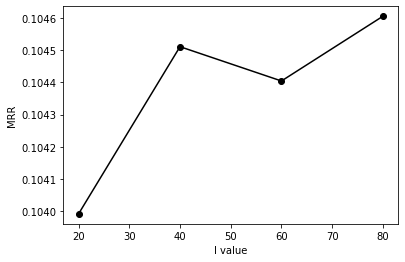

In [20]:
# investigate the impact of the number of tables (l) given k=5.
k = 5
l_list = [20,40,60,80]

mrr_list_l = []

# for each value of the number of tables l in l_list.
for l in l_list:
    # get top 10 ranked documents in search results
    search_res = get_search_result(k,l)
    mrr = 0
    
    # compute the mean reciprocal rank for each query
    for q in range(len(search_res)):
        q_top_ten = search_res[q][:10]
        #print(q_top_ten)
        # compute mrr_q for each query
        mrr_q = MRR_q(q_top_ten, ground_truth[q])
        mrr += mrr_q
    
    # average the mrr across all queries.
    mrr = mrr/len(search_res)
    mrr_list_l.append(mrr)

# the mrr value for each value of the number of tables l.
print("The mean reciprocal rank (MRR) values for each value of the number of tables l = [20,40,60,80] given k=5 are:")
print(mrr_list_l)

plt.plot(l_list, mrr_list_l, '-ok')
plt.xlabel("l value")
plt.ylabel("MRR")
plt.show()

### (b) Investigate the impact of the hash size ($k$).

The mean reciprocal rank (MRR) values for each value of the hash size k = [5,10,15,20] given l=20 are:
[0.10424469749731893, 0.10462039210364973, 0.1045199660177045, 0.10459746079164145]


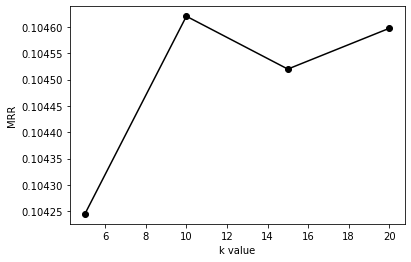

In [21]:
# investigate the impact of the hash size (k) given l=20.
l = 20
k_list = [5,10,15,20]

mrr_list_k = []

# for each value of the number of tables l
for k in k_list:
    # get top 10 ranked documents in search results
    search_res = get_search_result(k,l)
    mrr = 0
    
    # compute the mean reciprocal rank for each query
    for q in range(len(search_res)):
        q_top_ten = search_res[q][:10]
        # compute mrr_q for each query
        mrr_q = MRR_q(q_top_ten, ground_truth[q])
        mrr += mrr_q
    
    # average the mrr across all queries.
    mrr = mrr/len(search_res)
    mrr_list_k.append(mrr)

# the mrr value for each value of the hash size k.
print("The mean reciprocal rank (MRR) values for each value of the hash size k = [5,10,15,20] given l=20 are:")
print(mrr_list_k)    
    
plt.plot(k_list, mrr_list_k, '-ok')
plt.xlabel("k value")
plt.ylabel("MRR")
plt.show()

### (c) Explain the observation from Part III(a) and Part III(b). Tune the number of tables ($l$) and the hash size ($k$) to achieve better MRR.